## Module 3 Final Project Submission - Predicting Water Pump Functionality in Tanzania
* Student name: Emily J. Cain
* Student pace: Full Time
* Scheduled project review date/time: January 14, 2019
* Instructor name: Rafael Carrasco
* Blog post URL:

In [1]:
# Notes
# create functions / loops when necessary for DRY code
# consistent header sizes, viz colors
# Permit column? 
# violin plots
# put in links to take you to sections of the notebook
# omg use current variables

### Sources 
* DrivenData - Data Science Competitions with Social Impact
 * https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/
* Taarifa - an open source platform that helps citizens engage with their local government
 * http://taarifa.org/
* Tanzanian Ministry of Water
 * http://maji.go.tz/

## <a href='#section_1'>I. Load & Inspect the Data</a>
## <a href='#section_2'>II. Data Cleaning & Exploratory Data Analysis</a>
## <a href='#section_3'>III. Preprocessing</a>
## <a href='#section_4'>IV. Modeling</a>
## <a href='#section_5'>V. Conclusions & Further Questions</a>

### Targets for Water Pump Functionality
* Functioning
* Functioning, in need of repair
* Non-functioning

### Data Features
* amount_tsh - total static head - amount of water available to waterpoint / measure of water pressure
* date_recorded
* funder - who funded the well
* gps_height - altitude of the well
* installer - organization that installed the well
* longitude
* latitude
* wpt_name - name of waterpoint
* num_private
* basin 
* subvillage
* region
* region_code
* district_code
* lga - geographic location
* ward - geographic location
* population
* public_meeting
* recorded_by - group that collected the data for this well
* scheme_management - who operates the waterpoint
* scheme_name
* permit
* construction_year
* extraction_type
* extraction_type_group
* extraction_type_class
* management
* payment - what the water costs
* payment_type
* water_quality
* quality_group
* quantity
* quantity_group
* source - source of the water
* source_type
* source_class
* waterpoint_type
* waterpoint_type_group

In [294]:
import pandas as pd
import numpy as np
import time

from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, auc, classification_report, confusion_matrix, f1_score, make_scorer, recall_score, roc_curve
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.tree import DecisionTreeClassifier


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

#### Functions Used

In [2]:
def plot_feature_importances(model):
    
    """Visualize feature importance of selected model as determined by feature_importances_ method."""
    
    n_features = X_train.shape[1]
    plt.figure(figsize=(12,12))
    plt.barh(range(n_features), model.feature_importances_, align='center', color='purple') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature")

## I. Load & Inspect the Data<a id='section_1'></a>

In [3]:
feature_df = pd.read_csv('waterpumpfeatures.csv')
target_df = pd.read_csv('traintargets.csv')

In [4]:
feature_df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [5]:
feature_df.shape

(59400, 40)

In [6]:
target_df.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [7]:
target_df.shape

(59400, 2)

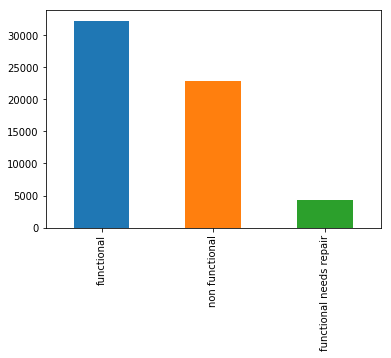

In [10]:
target_df.status_group.value_counts().plot(kind='bar');

In [11]:
df = pd.merge(target_df, feature_df, left_index=True, right_index=True)
df.head()

,id_x,status_group,id_y,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,functional,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,functional,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,functional,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,non functional,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,functional,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


#### Combine 'non functional' and 'needs repair' into one class

In [12]:
df.status_group.replace({'non functional': 'needs repair', 'functional needs repair': 'needs repair'}, inplace=True)

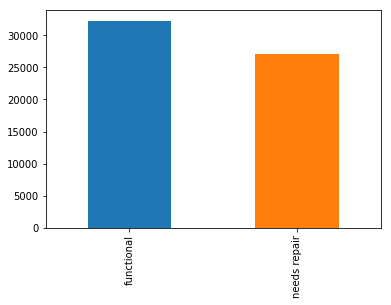

In [13]:
df.status_group.value_counts().plot(kind='bar');

#### Change target to binary variables

In [14]:
df.status_group.replace({'functional': 1, 'needs repair': 0}, inplace=True)

## II. Data Cleaning & Exploratory Data Analysis<a id='section_2'></a>

In [15]:
df.describe()

,id_x,status_group,id_y,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,0.543081,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,0.498145,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,1.000000,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,1.000000,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,1.000000,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [16]:
df.dtypes

id_x                       int64
status_group               int64
id_y                       int64
amount_tsh               float64
date_recorded             object
funder                    object
gps_height                 int64
installer                 object
longitude                float64
latitude                 float64
wpt_name                  object
num_private                int64
basin                     object
subvillage                object
region                    object
region_code                int64
district_code              int64
lga                       object
ward                      object
population                 int64
public_meeting            object
recorded_by               object
scheme_management         object
scheme_name               object
permit                    object
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management

#### Drop 'id' column

In [17]:
df.drop(['id_x', 'id_y'], axis=1, inplace=True)

In [18]:
df.head()

,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,1,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,1,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,1,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,0,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,1,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


#### Check for null and placeholder values

In [19]:
df.isnull().sum()

status_group                 0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

### Funder

In [21]:
df.funder.value_counts().nlargest(15)

Government Of Tanzania    9084
Danida                    3114
Hesawa                    2202
Rwssp                     1374
World Bank                1349
Kkkt                      1287
World Vision              1246
Unicef                    1057
Tasaf                      877
District Council           843
Dhv                        829
Private Individual         826
Dwsp                       811
0                          777
Norad                      765
Name: funder, dtype: int64

#### Replace null and '0' values in 'funder' column with 'Unknown'

In [22]:
df.funder.fillna('Unknown', inplace=True)

In [23]:
df.funder.replace({'0': 'Unknown'}, inplace=True)

In [24]:
df.funder.value_counts().nlargest(5)

Government Of Tanzania    9084
Unknown                   4416
Danida                    3114
Hesawa                    2202
Rwssp                     1374
Name: funder, dtype: int64

#### Drop 'funder' column from the dataset because this should not have a direct effect on functionality

In [25]:
df.drop('funder', axis=1, inplace=True)

### Installer

In [26]:
df.installer.value_counts().nlargest(10)

DWE                   17402
Government             1825
RWE                    1206
Commu                  1060
DANIDA                 1050
KKKT                    898
Hesawa                  840
0                       777
TCRS                    707
Central government      622
Name: installer, dtype: int64

#### Replace null and '0' values in 'installer' column with 'Unknown'

In [27]:
df.installer.replace({'0': 'Unknown', np.nan: 'Unknown'}, inplace=True)

In [28]:
df.installer.value_counts().nlargest(5)

DWE           17402
Unknown        4435
Government     1825
RWE            1206
Commu          1060
Name: installer, dtype: int64

#### Drop 'installer' column from the dataset because this should not have an impact of well functionality

In [29]:
df.drop('installer', axis=1, inplace=True)

### Subvillage

In [30]:
df.subvillage.value_counts().nlargest(10)

Madukani    508
Shuleni     506
Majengo     502
Kati        373
Mtakuja     262
Sokoni      232
M           187
Muungano    172
Mbuyuni     164
Mlimani     152
Name: subvillage, dtype: int64

In [31]:
len(df.subvillage.value_counts())

19287

#### Replace null values with 'Unknown'

In [32]:
df.subvillage.fillna('Unknown', inplace=True)

In [33]:
df.subvillage.isnull().sum()

0

#### Drop 'subvillage' from the dataset because the name of the village should not affect well functionality and there are better columns to describe location - if location is an important feature

In [34]:
df.drop('subvillage', axis=1, inplace=True)

### Public Meeting

In [35]:
df.public_meeting.value_counts().nlargest(50)

True     51011
False     5055
Name: public_meeting, dtype: int64

#### Unclear at this time what the 'public_meeting' column represents, but will replace null values with the majority value of 'True' and change the boolean values to 0 and 1

In [36]:
df.public_meeting.replace({'True': 1, 'False': 0, np.nan: 1}, inplace=True)

In [37]:
df.public_meeting.value_counts()

True     54345
False     5055
Name: public_meeting, dtype: int64

In [38]:
df.public_meeting.head()

0    True
1       1
2    True
3    True
4    True
Name: public_meeting, dtype: object

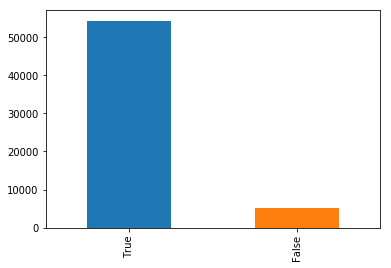

In [39]:
df.public_meeting.value_counts().plot(kind='bar');

### Scheme Management

In [40]:
df.scheme_management.value_counts()

VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

#### Replace null, 'Other', and 'None' values to 'Unknown'

In [41]:
df.scheme_management.replace({'None': 'Unknown', np.nan: 'Unknown', 'Other': 'Unknown'}, inplace=True)

In [42]:
df.scheme_management.value_counts()

VWC                 36793
WUG                  5206
Unknown              4644
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
SWC                    97
Trust                  72
Name: scheme_management, dtype: int64

#### Will drop 'scheme_management' from the dataset due to containing duplicate information

In [43]:
df.drop('scheme_management', axis=1, inplace=True)

### Scheme Name

In [44]:
df.scheme_name.value_counts().nlargest(10)

K                              682
None                           644
Borehole                       546
Chalinze wate                  405
M                              400
DANIDA                         379
Government                     320
Ngana water supplied scheme    270
wanging'ombe water supply s    261
wanging'ombe supply scheme     234
Name: scheme_name, dtype: int64

#### Replace null and 'None' values to 'Unknown'

In [45]:
df.scheme_name.replace({np.nan: 'Unknown', 'None': 'Unknown'}, inplace=True)

In [46]:
df.scheme_name.value_counts().nlargest(5)

Unknown          28810
K                  682
Borehole           546
Chalinze wate      405
M                  400
Name: scheme_name, dtype: int64

#### Drop 'scheme_name' from the dataset because the majority of values are unknown, and there could be duplicate values from 'scheme_management'

In [47]:
df.drop('scheme_name', axis=1, inplace=True)

### Permit

In [48]:
df.permit.value_counts()

True     38852
False    17492
Name: permit, dtype: int64

#### Change null values to 'Unknown' at this time

In [49]:
df.permit.fillna('Unknown', inplace=True)

In [50]:
df.isnull().sum()

status_group             0
amount_tsh               0
date_recorded            0
gps_height               0
longitude                0
latitude                 0
wpt_name                 0
num_private              0
basin                    0
region                   0
region_code              0
district_code            0
lga                      0
ward                     0
population               0
public_meeting           0
recorded_by              0
permit                   0
construction_year        0
extraction_type          0
extraction_type_group    0
extraction_type_class    0
management               0
management_group         0
payment                  0
payment_type             0
water_quality            0
quality_group            0
quantity                 0
quantity_group           0
source                   0
source_type              0
source_class             0
waterpoint_type          0
waterpoint_type_group    0
dtype: int64

### Amount TSH (Total static head)

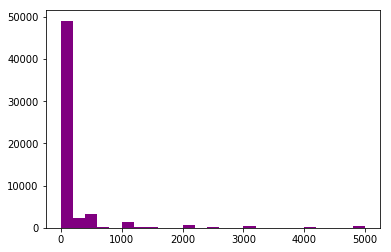

In [51]:
plt.hist(df.amount_tsh, color='purple', range=(0,5000), bins=25);

In [52]:
df.amount_tsh.value_counts().nlargest(10)

0.0       41639
500.0      3102
50.0       2472
1000.0     1488
20.0       1463
200.0      1220
100.0       816
10.0        806
30.0        743
2000.0      704
Name: amount_tsh, dtype: int64

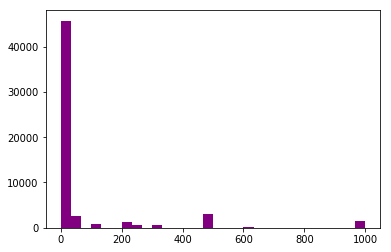

In [49]:
plt.hist(df.amount_tsh, color='purple', range=(0,1000), bins=30);

In [50]:
df.amount_tsh.mean()

317.6503846801347

#### Check to see if there is a relationship between 0 TSH and a well that needs repair, or if these are simply missing values.

In [68]:
# df.loc[(df.amount_tsh != 0.0) & (df.status_group == 1)]

In [69]:
# df.loc[(df.status_group == 0) & (df.amount_tsh == 0.0)]

In [70]:
# df.loc[(df.status_group == 0) & (df.amount_tsh != 0.0)]

In [71]:
# df.loc[(df.status_group == 1) & (df.amount_tsh == 0.0)]

In [66]:
functioning_wells = df.loc[df.status_group == 1]
print(f'The mean tsh of functioning wells is {functioning_wells.amount_tsh.mean()}')

The mean tsh of functioning wells is 461.79823460119655


In [67]:
non_functioning_wells = df.loc[df.status_group == 0]
print(f'The mean tsh of non-functioning wells is {non_functioning_wells.amount_tsh.mean()}')

The mean tsh of non-functioning wells is 146.32045982093513


#### Although some of the 0 TSH values are probably just missing values, the difference in mean TSH between the two types of wells seems large enough that a 0 value could be a predictor of a well that needs repair. Replacing the 0 values with different means would introduce bias into the model, so the 0 values will remain. 

### Date Recorded

In [72]:
date_df = df[['date_recorded', 'construction_year']]

In [73]:
date_df.head(10)

,date_recorded,construction_year
0,2011-03-14,1999
1,2013-03-06,2010
2,2013-02-25,2009
3,2013-01-28,1986
4,2011-07-13,0
5,2011-03-13,2009
6,2012-10-01,0
7,2012-10-09,0
8,2012-11-03,0
9,2011-08-03,0


In [74]:
date_df.tail(10)

,date_recorded,construction_year
59390,2011-08-04,1991
59391,2013-08-03,1967
59392,2011-04-15,0
59393,2012-10-27,0
59394,2011-03-09,2007
59395,2013-05-03,1999
59396,2011-05-07,1996
59397,2011-04-11,0
59398,2011-03-08,0
59399,2011-03-23,2002


#### The 'date_recorded' years are different from the 'construction_year' column, so this information should not have an impact on well functionality unless repairs were also made on these dates - which is not known. 

In [75]:
df.drop('date_recorded', axis=1, inplace=True)

### GPS Height

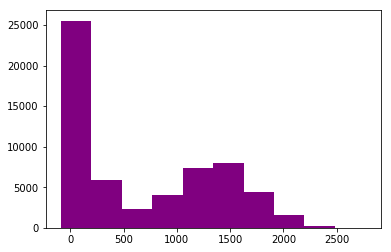

In [76]:
plt.hist(df.gps_height, color='purple');

In [77]:
print(f'The mean gps height of functioning wells is {functioning_wells.gps_height.mean()}')

The mean gps height of functioning wells is 740.1311881955423


In [78]:
print(f'The mean gps height of non-functioning wells is {non_functioning_wells.gps_height.mean()}')

The mean gps height of non-functioning wells is 582.9175048819129


#### The 'gps_height' distribution looks fairly normal without the 0 values, so the 0 values will be treated as missing values and will be replaced by the mean.

In [83]:
non_missing_heights = df.loc[df.gps_height != 0]
non_missing_heights_mean = non_missing_heights.gps_height.mean()
rounded_nmh_mean = int(round(non_missing_heights_mean))
rounded_nmh_mean

1019

In [84]:
df.gps_height.replace({0: rounded_nmh_mean}, inplace=True)

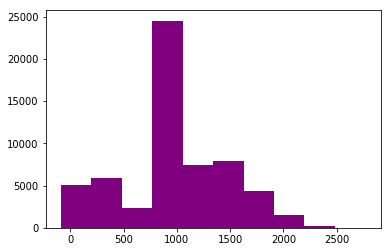

In [89]:
plt.hist(df.gps_height, color='purple', bins=10);

### Longitude

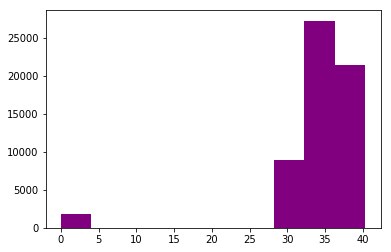

In [90]:
plt.hist(df.longitude, color='purple');

In [91]:
df.longitude.value_counts().nlargest(10)

0.000000     1812
37.540901       2
33.010510       2
39.093484       2
32.972719       2
33.006275       2
39.103950       2
37.542785       2
36.802490       2
39.098374       2
Name: longitude, dtype: int64

#### Replace missing values with the mean longitude

In [92]:
mean_long = round(df.longitude.mean(), 6)
mean_long

34.077427

In [93]:
df.longitude.replace({0.000000: mean_long}, inplace=True)

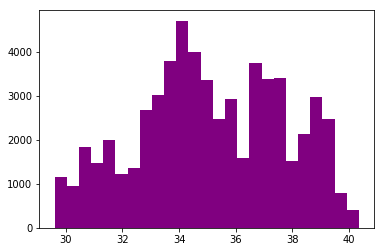

In [94]:
plt.hist(df.longitude, color='purple', bins=25);

### Latitude

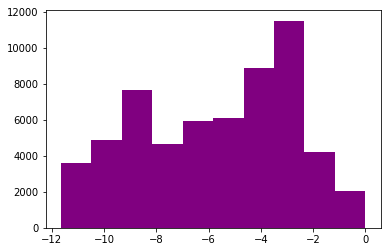

In [95]:
plt.hist(df.latitude, color='purple');

### Wpt name

In [96]:
df.wpt_name.value_counts().nlargest(10)

none               3563
Shuleni            1748
Zahanati            830
Msikitini           535
Kanisani            323
Bombani             271
Sokoni              260
Ofisini             254
School              208
Shule Ya Msingi     199
Name: wpt_name, dtype: int64

#### Change 'none' to 'Unknown'

In [97]:
df.wpt_name.replace({'none': 'Unknown'}, inplace=True)

In [98]:
df.wpt_name.value_counts().nlargest(5)

Unknown      3566
Shuleni      1748
Zahanati      830
Msikitini     535
Kanisani      323
Name: wpt_name, dtype: int64

#### Drop 'wpt_name' from the dataset because the name should not have an effect on well functionality

In [99]:
df.drop('wpt_name', axis=1, inplace=True)

### Num private

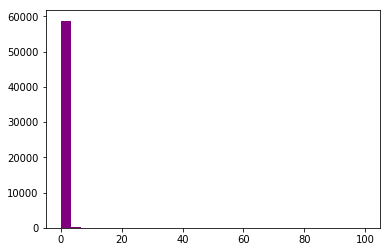

In [100]:
plt.hist(df.num_private, color='purple', range=(0,100), bins=30);

In [101]:
df.num_private.value_counts().nlargest(5)

0    58643
6       81
1       73
5       46
8       46
Name: num_private, dtype: int64

#### Unclear as to what this column represents with a majority of zero values, so will drop it from the dataset

In [102]:
df.drop('num_private', axis=1, inplace=True)

### Basin

In [103]:
df.basin.value_counts()

Lake Victoria              10248
Pangani                     8940
Rufiji                      7976
Internal                    7785
Lake Tanganyika             6432
Wami / Ruvu                 5987
Lake Nyasa                  5085
Ruvuma / Southern Coast     4493
Lake Rukwa                  2454
Name: basin, dtype: int64

### Region

In [104]:
df.region.value_counts()

Iringa           5294
Shinyanga        4982
Mbeya            4639
Kilimanjaro      4379
Morogoro         4006
Arusha           3350
Kagera           3316
Mwanza           3102
Kigoma           2816
Ruvuma           2640
Pwani            2635
Tanga            2547
Dodoma           2201
Singida          2093
Mara             1969
Tabora           1959
Rukwa            1808
Mtwara           1730
Manyara          1583
Lindi            1546
Dar es Salaam     805
Name: region, dtype: int64

In [105]:
len(df.region.value_counts())

21

#### Will drop the 'region' column from the dataset to avoid duplicating information

In [106]:
df.drop('region', axis=1, inplace=True)

### Region code

In [107]:
df.region_code.value_counts()

11    5300
17    5011
12    4639
3     4379
5     4040
18    3324
19    3047
2     3024
16    2816
10    2640
4     2513
1     2201
13    2093
14    1979
20    1969
15    1808
6     1609
21    1583
80    1238
60    1025
90     917
7      805
99     423
9      390
24     326
8      300
40       1
Name: region_code, dtype: int64

In [108]:
len(df.region_code.value_counts())

27

#### Will drop 'region_code' from the dataset because 'latitude' and 'longitude' will be used for location features

In [109]:
df.drop('region_code', axis=1, inplace=True)

### District code

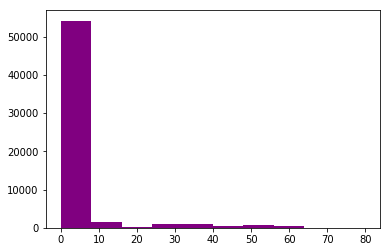

In [110]:
plt.hist(df.district_code, color='purple');

In [111]:
df.district_code.value_counts()

1     12203
2     11173
3      9998
4      8999
5      4356
6      4074
7      3343
8      1043
30      995
33      874
53      745
43      505
13      391
23      293
63      195
62      109
60       63
0        23
80       12
67        6
Name: district_code, dtype: int64

In [112]:
len(df.district_code.value_counts())

20

#### Will drop 'district_code' from the dataset because 'latitude' and 'longitude' will be used as location features

In [113]:
df.drop('district_code', axis=1, inplace=True)

### LGA

In [114]:
df.lga.value_counts().nlargest(10)

Njombe          2503
Arusha Rural    1252
Moshi Rural     1251
Bariadi         1177
Rungwe          1106
Kilosa          1094
Kasulu          1047
Mbozi           1034
Meru            1009
Bagamoyo         997
Name: lga, dtype: int64

#### Will drop 'lga' from the dataset because there are more concise location columns

In [115]:
df.drop('lga', axis=1, inplace=True)

### Ward

In [116]:
df.ward.value_counts().nlargest(10)

Igosi           307
Imalinyi        252
Siha Kati       232
Mdandu          231
Nduruma         217
Mishamo         203
Kitunda         203
Msindo          201
Chalinze        196
Maji ya Chai    190
Name: ward, dtype: int64

#### Will drop 'ward' from the dataset because there are more concise location columns

In [117]:
df.drop('ward', axis=1, inplace=True)

### Population

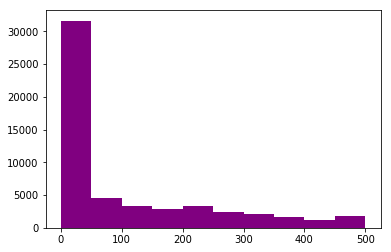

In [118]:
plt.hist(df.population, color='purple', range=(0,500));

In [121]:
df.population.value_counts().nlargest(5)

0      21381
1       7025
200     1940
150     1892
250     1681
Name: population, dtype: int64

In [126]:
non_zero_pop = df.loc[df.population != 0]
non_zero_pop_mean = non_zero_pop.population.mean()
non_zero_pop_mean

281.08716694284436

#### Since it is unlikely a well would be built where the population is 0, the 0 values will be treated as missing values and will be replaced by the mean population. Even if a well is built in a area where nobody lives - but where people may travel - that well will still be used. Population value could indicate a 'wear and tear' affect on the wells.

In [127]:
rounded_pop_mean = int(round(non_zero_pop_mean))
rounded_pop_mean

281

In [128]:
df.population.replace({0: rounded_pop_mean}, inplace=True)

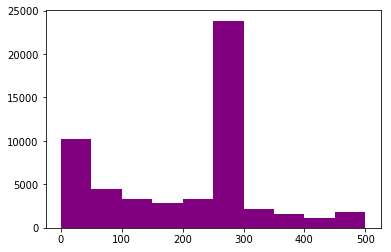

In [130]:
plt.hist(df.population, color='purple', range=(0,500));

#### Examine outlier populations

In [134]:
df.loc[df.population > 10000]

,status_group,amount_tsh,gps_height,longitude,latitude,basin,population,public_meeting,recorded_by,permit,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
14308,0,0.0,1084,36.386050,-4.787678,Internal,15300,True,GeoData Consultants Ltd,False,...,never pay,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,communal standpipe,communal standpipe
30537,1,0.0,184,38.783756,-5.181904,Pangani,30500,True,GeoData Consultants Ltd,False,...,never pay,salty,salty,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump
51398,1,50.0,26,38.727663,-6.724701,Wami / Ruvu,11463,True,GeoData Consultants Ltd,True,...,per bucket,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe


### Recorded by

In [135]:
df.recorded_by.value_counts()

GeoData Consultants Ltd    59400
Name: recorded_by, dtype: int64

#### Will drop the 'recorded_by' column from the dataset since all values are the same

In [136]:
df.drop('recorded_by', axis=1, inplace=True)

### Construction year

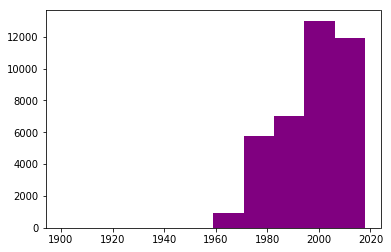

In [137]:
plt.hist(df.construction_year, color='purple', range=(1900,2018));

In [138]:
df.construction_year.value_counts().nlargest(10)

0       20709
2010     2645
2008     2613
2009     2533
2000     2091
2007     1587
2006     1471
2003     1286
2011     1256
2004     1123
Name: construction_year, dtype: int64

In [139]:
df.construction_year.median()

1986.0

In [140]:
len(df.construction_year.value_counts())

55

#### Check for shared properties between wells built in the same year as a possible way to populate missing values

In [141]:
# df.loc[df.construction_year == 1986]

In [142]:
# df.loc[df.construction_year == 2000]

In [143]:
# df.loc[df.construction_year == 1970]

#### There are no obvious shared properties between wells built in the same year, so populating the large number of missing values could negatively affect the model. Additionally, converting this column to a categorical variable would vastly increase dimensionality with so many dummy variables, so this column will be dropped from the dataset.

In [144]:
df.drop('construction_year', axis=1, inplace=True)

### Extraction type

In [145]:
df.extraction_type.value_counts()

gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  98
cemo                            90
other - play pump               85
walimi                          48
climax                          32
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64

#### Drop 'extraction_type' column from the dataset due to containing brand names of pumps and duplicating information

In [146]:
df.drop('extraction_type', axis=1, inplace=True)

### Extraction type group

In [147]:
df.extraction_type_group.value_counts()

gravity            26780
nira/tanira         8154
other               6430
submersible         6179
swn 80              3670
mono                2865
india mark ii       2400
afridev             1770
rope pump            451
other handpump       364
other motorpump      122
wind-powered         117
india mark iii        98
Name: extraction_type_group, dtype: int64

#### Drop 'extraction_type_group' column from the dataset due to containing brand names of pumps and duplicating information

In [148]:
df.drop('extraction_type_group', axis=1, inplace=True)

### Extraction type class

In [149]:
df.extraction_type_class.value_counts()

gravity         26780
handpump        16456
other            6430
submersible      6179
motorpump        2987
rope pump         451
wind-powered      117
Name: extraction_type_class, dtype: int64

### Management

In [150]:
df.management.value_counts()

vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64

#### Consolidate 'other' values with 'unknown' and change 'other - school' to 'school' for clarity

In [151]:
df.management.replace({'other': 'unknown', 'other - school': 'school'}, inplace=True)

In [152]:
df.management.value_counts()

vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
unknown              1405
water authority       904
company               685
school                 99
trust                  78
Name: management, dtype: int64

### Management group

In [153]:
df.management_group.value_counts()

user-group    52490
commercial     3638
parastatal     1768
other           943
unknown         561
Name: management_group, dtype: int64

#### Drop 'management_group' column from the dataset due to containing duplicate but less informative values

In [154]:
df.drop('management_group', axis=1, inplace=True)

### Payment

In [155]:
df.payment.value_counts()

never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: payment, dtype: int64

#### Drop 'payment' column from the dataset due to containing duplicate information

In [156]:
df.drop('payment', axis=1, inplace=True)

### Payment type

In [157]:
df.payment_type.value_counts()

never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: payment_type, dtype: int64

#### Consolidate 'other' with 'unknown' values

In [158]:
df.payment_type.replace({'other': 'unknown'}, inplace=True)

In [159]:
df.payment_type.value_counts()

never pay     25348
unknown        9211
per bucket     8985
monthly        8300
on failure     3914
annually       3642
Name: payment_type, dtype: int64

#### Payment type should not have an effect on well functionality, unless payment type is determined by some feature of the well.

### Water Quality

In [160]:
df.water_quality.value_counts()

soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: water_quality, dtype: int64

#### Drop 'water_quality' column from the dataset due to containing duplicate, less-concise information than 'quality_group'

In [161]:
df.drop('water_quality', axis=1, inplace=True)

### Quality Group

In [162]:
df.quality_group.value_counts()

good        50818
salty        5195
unknown      1876
milky         804
colored       490
fluoride      217
Name: quality_group, dtype: int64

### Quantity

In [163]:
df.quantity.value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity, dtype: int64

### Quantity Group

In [164]:
df.quantity_group.value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity_group, dtype: int64

#### Drop 'quantity_group' column from dataset due to containing duplicate information

In [165]:
df.drop('quantity_group', axis=1, inplace=True)

### Source

In [166]:
df.source.value_counts()

spring                  17021
shallow well            16824
machine dbh             11075
river                    9612
rainwater harvesting     2295
hand dtw                  874
lake                      765
dam                       656
other                     212
unknown                    66
Name: source, dtype: int64

#### Drop 'source' column from the dataset due to containing duplicate information

In [167]:
df.drop('source', axis=1, inplace=True)

### Source Type

In [168]:
df.source_type.value_counts()

spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: source_type, dtype: int64

### Source Class

In [169]:
df.source_class.value_counts()

groundwater    45794
surface        13328
unknown          278
Name: source_class, dtype: int64

#### Drop 'source_class' column due to containing duplicate, less-informative values than the 'source_type' column

In [170]:
df.drop('source_class', axis=1, inplace=True)

### Waterpoint Type

In [171]:
df.waterpoint_type.value_counts()

communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64

#### Drop 'waterpoint_type' column due to containing duplicate information

In [172]:
df.drop('waterpoint_type', axis=1, inplace=True)

### Waterpoint Type Group

In [173]:
df.waterpoint_type_group.value_counts()

communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64

## III. Preprocessing<a id='section_3'></a>

In [174]:
df.head()

,status_group,amount_tsh,gps_height,longitude,latitude,basin,population,public_meeting,permit,extraction_type_class,management,payment_type,quality_group,quantity,source_type,waterpoint_type_group
0,1,6000.0,1390,34.938093,-9.856322,Lake Nyasa,109,True,False,gravity,vwc,annually,good,enough,spring,communal standpipe
1,1,0.0,1399,34.698766,-2.147466,Lake Victoria,280,1,True,gravity,wug,never pay,good,insufficient,rainwater harvesting,communal standpipe
2,1,25.0,686,37.460664,-3.821329,Pangani,250,True,True,gravity,vwc,per bucket,good,enough,dam,communal standpipe
3,0,0.0,263,38.486161,-11.155298,Ruvuma / Southern Coast,58,True,True,submersible,vwc,never pay,good,dry,borehole,communal standpipe
4,1,0.0,1019,31.130847,-1.825359,Lake Victoria,281,True,True,gravity,unknown,never pay,good,seasonal,rainwater harvesting,communal standpipe


In [175]:
df.dtypes

status_group               int64
amount_tsh               float64
gps_height                 int64
longitude                float64
latitude                 float64
basin                     object
population                 int64
public_meeting            object
permit                    object
extraction_type_class     object
management                object
payment_type              object
quality_group             object
quantity                  object
source_type               object
waterpoint_type_group     object
dtype: object

#### Change type for boolean columns

In [176]:
df.public_meeting = df.public_meeting.astype('bool')
df.permit = df.permit.astype('bool')

In [177]:
df.dtypes

status_group               int64
amount_tsh               float64
gps_height                 int64
longitude                float64
latitude                 float64
basin                     object
population                 int64
public_meeting              bool
permit                      bool
extraction_type_class     object
management                object
payment_type              object
quality_group             object
quantity                  object
source_type               object
waterpoint_type_group     object
dtype: object

#### Split the dataframe into target and feature variables

In [178]:
y = df.status_group

In [179]:
y.head()

0    1
1    1
2    1
3    0
4    1
Name: status_group, dtype: int64

In [180]:
y.value_counts()

1    32259
0    27141
Name: status_group, dtype: int64

In [181]:
y.dtypes

dtype('int64')

In [182]:
X = df.drop('status_group', axis=1)

In [183]:
X.head()

,amount_tsh,gps_height,longitude,latitude,basin,population,public_meeting,permit,extraction_type_class,management,payment_type,quality_group,quantity,source_type,waterpoint_type_group
0,6000.0,1390,34.938093,-9.856322,Lake Nyasa,109,True,False,gravity,vwc,annually,good,enough,spring,communal standpipe
1,0.0,1399,34.698766,-2.147466,Lake Victoria,280,True,True,gravity,wug,never pay,good,insufficient,rainwater harvesting,communal standpipe
2,25.0,686,37.460664,-3.821329,Pangani,250,True,True,gravity,vwc,per bucket,good,enough,dam,communal standpipe
3,0.0,263,38.486161,-11.155298,Ruvuma / Southern Coast,58,True,True,submersible,vwc,never pay,good,dry,borehole,communal standpipe
4,0.0,1019,31.130847,-1.825359,Lake Victoria,281,True,True,gravity,unknown,never pay,good,seasonal,rainwater harvesting,communal standpipe


#### Convert categorical columns to dummy variables

In [184]:
X = pd.get_dummies(X)

In [185]:
X.head()

,amount_tsh,gps_height,longitude,latitude,population,public_meeting,permit,basin_Internal,basin_Lake Nyasa,basin_Lake Rukwa,...,source_type_rainwater harvesting,source_type_river/lake,source_type_shallow well,source_type_spring,waterpoint_type_group_cattle trough,waterpoint_type_group_communal standpipe,waterpoint_type_group_dam,waterpoint_type_group_hand pump,waterpoint_type_group_improved spring,waterpoint_type_group_other
0,6000.0,1390,34.938093,-9.856322,109,True,False,0,1,0,...,0,0,0,1,0,1,0,0,0,0
1,0.0,1399,34.698766,-2.147466,280,True,True,0,0,0,...,1,0,0,0,0,1,0,0,0,0
2,25.0,686,37.460664,-3.821329,250,True,True,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0.0,263,38.486161,-11.155298,58,True,True,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0.0,1019,31.130847,-1.825359,281,True,True,0,0,0,...,1,0,0,0,0,1,0,0,0,0


#### Scale data using RobustScaler due to presence of outliers and non-normal distributions

In [186]:
# scaler = RobustScaler()
# scaled_X = scaler.fit_transform(X)

In [187]:
# scaled_X

In [188]:
# scaled_df = pd.DataFrame(scaled_X, index=X.index, columns=X.columns)

In [189]:
# scaled_df.head()

In [190]:
# plt.hist(scaled_df.gps_height, color='purple');

In [191]:
# plt.hist(scaled_df.population, color='purple');

#### Scale using StandardScaler

In [192]:
s_scaler = StandardScaler()
standard_X = s_scaler.fit_transform(X)

In [193]:
standard_df = pd.DataFrame(standard_X, index=X.index, columns=X.columns)

In [194]:
standard_df.head()

,amount_tsh,gps_height,longitude,latitude,population,public_meeting,permit,basin_Internal,basin_Lake Nyasa,basin_Lake Rukwa,...,source_type_rainwater harvesting,source_type_river/lake,source_type_shallow well,source_type_spring,waterpoint_type_group_cattle trough,waterpoint_type_group_communal standpipe,waterpoint_type_group_dam,waterpoint_type_group_hand pump,waterpoint_type_group_improved spring,waterpoint_type_group_other
0,1.895665,0.748008,-0.069492,-1.408791,-0.380855,0.304987,-1.547850,-0.388366,3.268244,-0.20759,...,-0.200472,-0.460083,-0.628611,1.577912,-0.044234,0.845886,-0.010856,-0.645953,-0.115651,-0.346889
1,-0.105970,0.766149,-0.162472,1.207934,-0.002337,0.304987,0.646058,-0.388366,-0.305975,-0.20759,...,4.988221,-0.460083,-0.628611,-0.633749,-0.044234,0.845886,-0.010856,-0.645953,-0.115651,-0.346889
2,-0.097630,-0.671043,0.910551,0.639751,-0.068744,0.304987,0.646058,-0.388366,-0.305975,-0.20759,...,-0.200472,-0.460083,-0.628611,-0.633749,-0.044234,0.845886,-0.010856,-0.645953,-0.115651,-0.346889
3,-0.105970,-1.523683,1.308966,-1.849720,-0.493746,0.304987,0.646058,-0.388366,-0.305975,-0.20759,...,-0.200472,-0.460083,-0.628611,-0.633749,-0.044234,0.845886,-0.010856,-0.645953,-0.115651,-0.346889
4,-0.105970,0.000184,-1.548642,1.317271,-0.000123,0.304987,0.646058,-0.388366,-0.305975,-0.20759,...,4.988221,-0.460083,-0.628611,-0.633749,-0.044234,0.845886,-0.010856,-0.645953,-0.115651,-0.346889


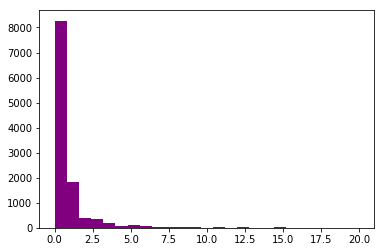

In [195]:
plt.hist(standard_df.population, color='purple', range=(0,20), bins=25);

## IV. Modeling<a id='section_4'></a>

In [196]:
X_train, X_test, y_train, y_test = train_test_split(standard_df, y, random_state=19)

#### Vanilla Decision Tree Classifier with standard scaled data

In [197]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [198]:
y_preds = dt.predict(X_test)

In [199]:
accuracy_score(y_test, y_preds)

0.7780471380471381

#### Vanilla Random Forest Classifier with standard scaled data

In [200]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [201]:
y_preds = rf.predict(X_test)

In [202]:
accuracy_score(y_test, y_preds)

0.8006734006734006

In [203]:
print(confusion_matrix(y_test, y_preds))
print(classification_report(y_test, y_preds))

[[5302 1436]
 [1524 6588]]
              precision    recall  f1-score   support

           0       0.78      0.79      0.78      6738
           1       0.82      0.81      0.82      8112

   micro avg       0.80      0.80      0.80     14850
   macro avg       0.80      0.80      0.80     14850
weighted avg       0.80      0.80      0.80     14850



In [204]:
# tune model to increase recall score for 'needs repair'

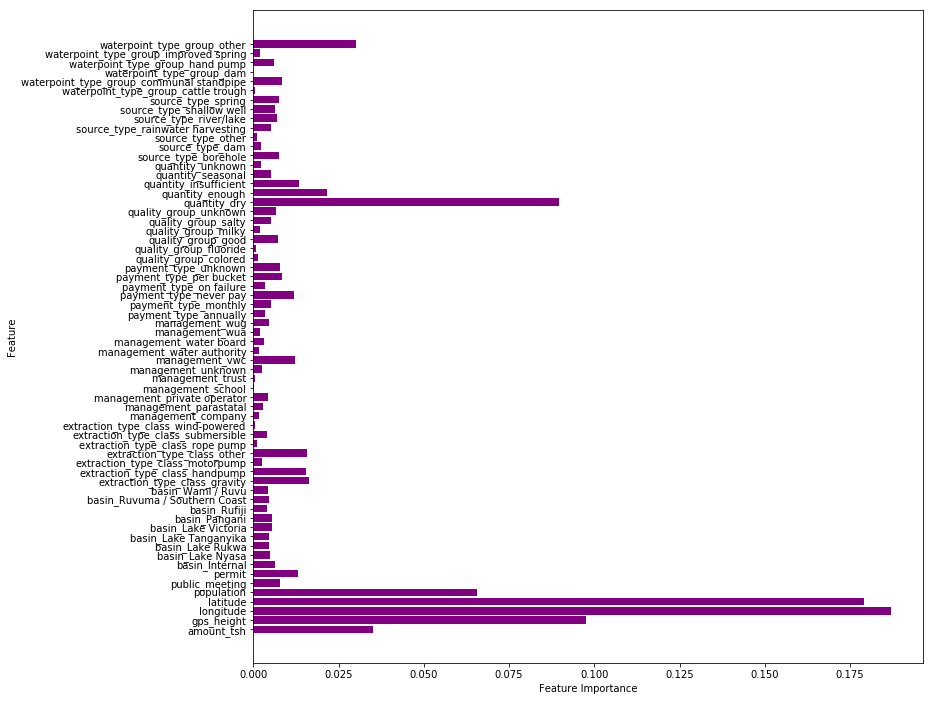

In [205]:
plot_feature_importances(rf)

#### Fit a vanilla random forest classifier with robust scaled data

In [206]:
# X_train, X_test, y_train, y_test = train_test_split(scaled_df, y)

In [207]:
# rf = RandomForestClassifier()
# rf.fit(X_train, y_train)

In [208]:
# y_preds = rf.predict(X_test)

In [209]:
# print(accuracy_score(y_test, y_preds) * 100)
# print(classification_report(y_test, y_preds))

In [210]:
# The standard scaled data provides slightly better scores, so that will be the scaler used

#### Visualize different hyperparameter values for a Random Forest Classifier and their effect on roc_auc

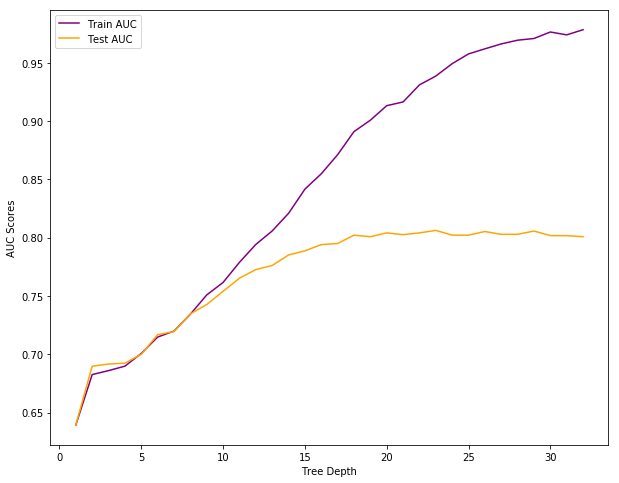

In [211]:
# Visualize effect of different max_depths on AUC scores

max_depths = np.linspace(1,32,32,endpoint=True)
train_auc = []
test_auc = []

for depth in max_depths:
    
    rf = RandomForestClassifier(max_depth=depth)
    rf.fit(X_train, y_train)
    train_pred = rf.predict(X_train)
    fpr, tpr, thresh = roc_curve(y_train, train_pred)
    roc_auc = auc(fpr, tpr)
    train_auc.append(roc_auc)
    
    test_pred = rf.predict(X_test)
    fpr, tpr, thresh = roc_curve(y_test, test_pred)
    roc_auc = auc(fpr, tpr)
    test_auc.append(roc_auc)

plt.figure(figsize=(10,8))
plt.plot(max_depths, train_auc, color='purple', label='Train AUC')
plt.plot(max_depths, test_auc, color='orange', label='Test AUC')
plt.xlabel('Tree Depth')
plt.ylabel('AUC Scores')
plt.legend(loc='best')
plt.show();

In [212]:
# For GridSearch, try max_depths around 5-15

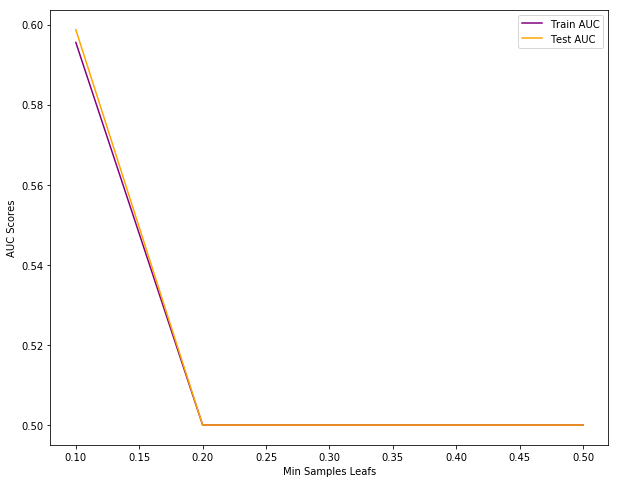

In [213]:
# Visualize effect of different min_samples_leaf on AUC scores

min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_auc = []
test_auc = []

for leaf in min_samples_leafs:
    
    rf = RandomForestClassifier(min_samples_leaf=leaf)
    rf.fit(X_train, y_train)
    train_pred = rf.predict(X_train)
    fpr, tpr, thresh = roc_curve(y_train, train_pred)
    roc_auc = auc(fpr, tpr)
    train_auc.append(roc_auc)
    
    test_pred = rf.predict(X_test)
    fpr, tpr, thresh = roc_curve(y_test, test_pred)
    roc_auc = auc(fpr, tpr)
    test_auc.append(roc_auc)

plt.figure(figsize=(10,8))
plt.plot(min_samples_leafs, train_auc, color='purple', label='Train AUC')
plt.plot(min_samples_leafs, test_auc, color='orange', label='Test AUC')
plt.xlabel('Min Samples Leafs')
plt.ylabel('AUC Scores')
plt.legend(loc='best')
plt.show();

In [214]:
# Will use values around 0.1 for min_samples_leaf in GridSearch

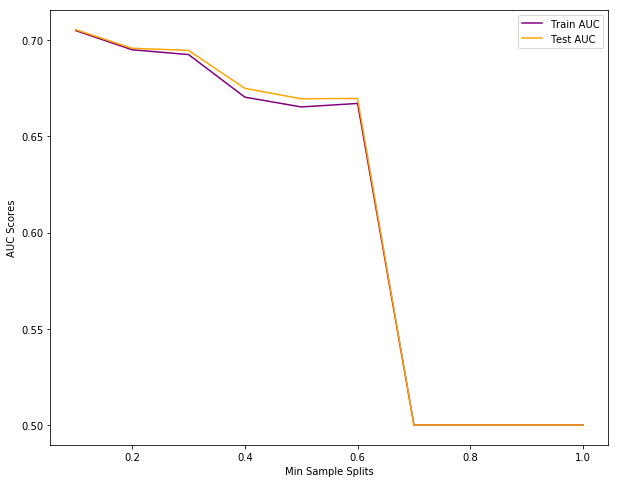

In [215]:
# Visualize AUC scores for different values of min_sample_splits

min_sample_splits = np.linspace(0.1, 1, 10, endpoint=True)
train_auc = []
test_auc = []

for split in min_sample_splits:
    
    rf = RandomForestClassifier(min_samples_split=split)
    rf.fit(X_train, y_train)
    train_pred = rf.predict(X_train)
    fpr, tpr, thresh = roc_curve(y_train, train_pred)
    roc_auc = auc(fpr, tpr)
    train_auc.append(roc_auc)
    
    test_pred = rf.predict(X_test)
    fpr, tpr, thresh = roc_curve(y_test, test_pred)
    roc_auc = auc(fpr, tpr)
    test_auc.append(roc_auc)

plt.figure(figsize=(10,8))
plt.plot(min_sample_splits, train_auc, color='purple', label='Train AUC')
plt.plot(min_sample_splits, test_auc, color='orange', label='Test AUC')
plt.xlabel('Min Sample Splits')
plt.ylabel('AUC Scores')
plt.legend(loc='best')
plt.show();

In [216]:
# Similar to min_samples_leaf, the smallest values lead to greater AUC scores

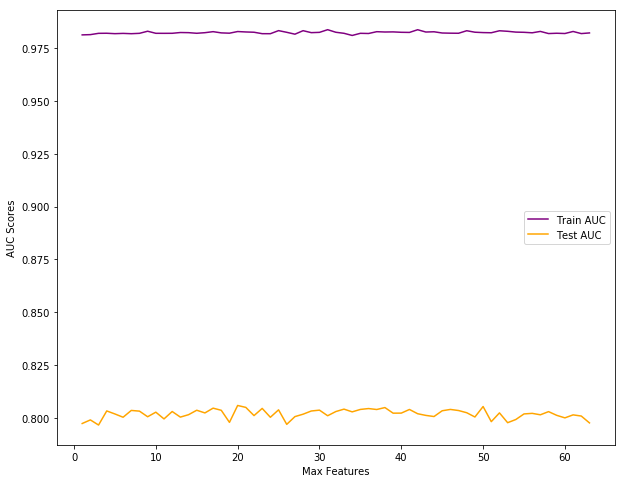

In [217]:
# Compare AUC scores from 1 feature to all features

max_features = list(range(1,X_train.shape[1]))
train_auc = []
test_auc = []

for feature in max_features:
    
    rf = RandomForestClassifier(max_features=feature)
    rf.fit(X_train, y_train)
    train_pred = rf.predict(X_train)
    fpr, tpr, thresh = roc_curve(y_train, train_pred)
    roc_auc = auc(fpr, tpr)
    train_auc.append(roc_auc)
    
    test_pred = rf.predict(X_test)
    fpr, tpr, thresh = roc_curve(y_test, test_pred)
    roc_auc = auc(fpr, tpr)
    test_auc.append(roc_auc)

plt.figure(figsize=(10,8))
plt.plot(max_features, train_auc, color='purple', label='Train AUC')
plt.plot(max_features, test_auc, color='orange', label='Test AUC')
plt.xlabel('Max Features')
plt.ylabel('AUC Scores')
plt.legend(loc='best')
plt.show();

In [218]:
# The above plot indicates overfitting for any number of max_features, but the RandomForestClassifier only 
# 'considers' this number when searching for the best split

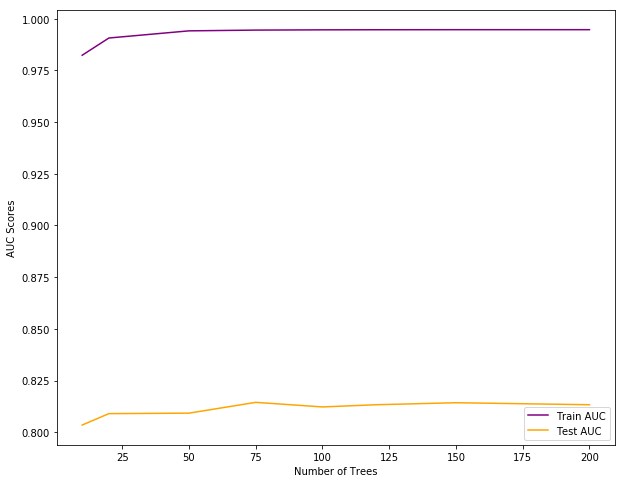

In [219]:
# Visualize effect of number of trees on AUC scores

n_estimators = [10, 20, 50, 75, 100, 120, 150, 200]
train_auc = []
test_auc = []

for estimator in n_estimators:
    
    rf = RandomForestClassifier(n_estimators=estimator)
    rf.fit(X_train, y_train)
    train_pred = rf.predict(X_train)
    fpr, tpr, thresh = roc_curve(y_train, train_pred)
    roc_auc = auc(fpr, tpr)
    train_auc.append(roc_auc)
    
    test_pred = rf.predict(X_test)
    fpr, tpr, thresh = roc_curve(y_test, test_pred)
    roc_auc = auc(fpr, tpr)
    test_auc.append(roc_auc)

plt.figure(figsize=(10,8))
plt.plot(n_estimators, train_auc, color='purple', label='Train AUC')
plt.plot(n_estimators, test_auc, color='orange', label='Test AUC')
plt.xlabel('Number of Trees')
plt.ylabel('AUC Scores')
plt.legend(loc='best')
plt.show();

In [220]:
# Will not be needing a huge forest of trees as having more than 25 trees does not affect the AUC score much

### GridSearch
#### Optimize for recall score - it is preferable to find a well that has been classified as 'needs repair' to actually be functioning, than to overlook a well that needs repair and has been classified as 'functioning'

In [331]:
# New RandomForestClassifier using some of the values from above plots

rf = RandomForestClassifier(min_samples_split=0.1, min_samples_leaf=0.1, random_state=19)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=0.1, min_samples_split=0.1,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=19, verbose=0, warm_start=False)

In [332]:
y_preds = rf.predict(X_test)
print(confusion_matrix(y_test, y_preds))
print(classification_report(y_test, y_preds))
print(recall_score(y_test, y_preds))

[[3290 3448]
 [1833 6279]]
              precision    recall  f1-score   support

           0       0.64      0.49      0.55      6738
           1       0.65      0.77      0.70      8112

   micro avg       0.64      0.64      0.64     14850
   macro avg       0.64      0.63      0.63     14850
weighted avg       0.64      0.64      0.64     14850

0.7740384615384616


In [333]:
rf_param_grid = {
    'n_estimators': [10, 50, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [0.1, 0.5, 0.7, 0.9],
    'min_samples_leaf': [0.1, 0.3, 0.5]
}

score = {
    'f1_score': make_scorer(f1_score)
}

num_perm = 3 * 2 * 4 * 4 * 3
print(f'GridSearch will search through {num_perm} different permutations.')

GridSearch will search through 288 different permutations.


In [334]:
# start_time = time.time()

# rf_grid_search = GridSearchCV(rf, rf_param_grid, scoring=score, cv=3, refit='f1_score')
# rf_grid_search.fit(standard_df, y)

# print(f'Best Score: {rf_grid_search.best_score_ * 100}%')
# print(f'Total Runtime: {time.time() - start_time} seconds')
# print('')
# print(f'Optimal Parameters: {rf_grid_search.best_params_}')

Best Score: 73.17475001138024%
Total Runtime: 269.86589217185974 seconds

Optimal Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 0.1, 'min_samples_split': 0.1, 'n_estimators': 10}


#### Results of 1st Random Forest GridSearch
* Best Score: 73.17475001138024%
* Total Runtime: 269.86589217185974 seconds
* Optimal Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 0.1, 'min_samples_split': 0.1, 'n_estimators': 10}

In [ ]:
rf2 = RandomForestClassifier(criterion='gini')

In [335]:
rf_param_grid2 = {
    'n_estimators': [5, 10, 15],
    'min_samples_split': [0.02, 0.05, 0.09],
    'min_samples_leaf': [0.02, 0.05, 0.09],
}

num_perm2 = 3 * 3 * 3
print(f'GridSearch2 will search through {num_perm2} different permutations.')

GridSearch2 will search through 27 different permutations.


In [336]:
start_time = time.time()

rf_grid_search2 = GridSearchCV(rf, rf_param_grid2, scoring=score, cv=3, refit='f1_score')
rf_grid_search2.fit(standard_df, y)

print(f'Best Score: {rf_grid_search2.best_score_ * 100}%')
print(f'Total Runtime: {time.time() - start_time} seconds')
print('')
print(f'Optimal Parameters: {rf_grid_search2.best_params_}')

Best Score: 77.9534006252322%
Total Runtime: 12.144890069961548 seconds

Optimal Parameters: {'min_samples_leaf': 0.02, 'min_samples_split': 0.02, 'n_estimators': 15}


#### Results of 2nd Random Forest GridSearch
* Best Score: 77.9534006252322%
* Total Runtime: 12.144890069961548 seconds

* Optimal Parameters: {'min_samples_leaf': 0.02, 'min_samples_split': 0.02, 'n_estimators': 15}

In [338]:
rf_param_grid3 = {
    'n_estimators': [15, 22, 35],
    'min_samples_leaf': [0.01, 0.02]
}

num_perm3 = 3 * 2
print(f'GridSearch3 will search through {num_perm3} different permutations.')

GridSearch3 will search through 6 different permutations.


In [339]:
rf_grid_search3 = GridSearchCV(rf, rf_param_grid3, cv=3, scoring=score, refit='f1_score')
rf_grid_search3.fit(standard_df, y)

print(f'Best Score: {rf_grid_search3.best_score_ * 100}%')
print(f'Optimal Parameters: {rf_grid_search3.best_params_}')

Testing Accuracy: 78.18166639329964%
Optimal Parameters: {'min_samples_leaf': 0.02, 'n_estimators': 35}


#### Results of 3rd Random Forest GridSearch
* Best Score: 78.18166639329964%
* Optimal Parameters: {'min_samples_leaf': 0.02, 'n_estimators': 35}

In [229]:
rf_param_grid4 = {
    'n_estimators': [8, 9],
}

score = {
    'recall_score': make_scorer(recall_score)
}

num_perm4 = 2 * 6 * 2 * 2
print(f'GridSearch4 will search through {num_perm4} different permutations.')

GridSearch4 will search through 48 different permutations.


In [230]:
# rf_grid_search4 = GridSearchCV(rf, rf_param_grid4, cv=3, scoring=score, refit='recall_score')
# rf_grid_search4.fit(standard_df, y)

# print(f'Testing Accuracy: {rf_grid_search4.best_score_ * 100}%')
# print(f'Total Runtime: {time.time() - start_time} seconds')
# print('')
# print(f'Optimal Parameters: {rf_grid_search4.best_params_}')

Testing Accuracy: 93.40339130165226%
Total Runtime: 82.73991394042969 seconds

Optimal Parameters: {'max_features': 4, 'min_samples_leaf': 0.02, 'min_samples_split': 0.02, 'n_estimators': 8}


#### Results of 4th Random Forest GridSearch
* Testing Accuracy: 93.40339130165226%
* Total Runtime: 82.73991394042969 seconds
* Optimal Parameters: {'max_features': 4, 'min_samples_leaf': 0.02, 'min_samples_split': 0.02, 'n_estimators': 8}

In [231]:
X_train, X_test, y_train, y_test = train_test_split(standard_df, y, random_state=19)
rf4 = RandomForestClassifier(min_samples_leaf=0.02, min_samples_split=0.02, n_estimators=8, max_features=4)
rf4.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=4, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=0.02, min_samples_split=0.02,
            min_weight_fraction_leaf=0.0, n_estimators=8, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [232]:
y_preds = rf4.predict(X_test)
print(confusion_matrix(y_test, y_preds))
print(classification_report(y_test, y_preds))

[[3481 3257]
 [1116 6996]]
              precision    recall  f1-score   support

           0       0.76      0.52      0.61      6738
           1       0.68      0.86      0.76      8112

   micro avg       0.71      0.71      0.71     14850
   macro avg       0.72      0.69      0.69     14850
weighted avg       0.72      0.71      0.69     14850



#### Using GridSearch to optimize the Random Forest Classifier only midly improved its performance, so another model may work better with this data.

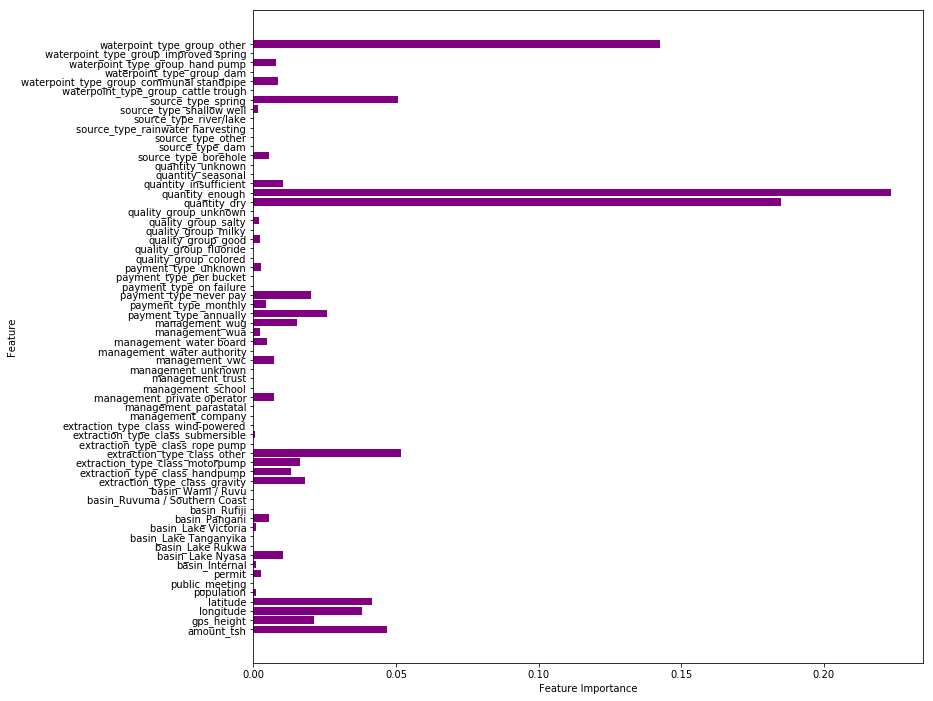

In [233]:
plot_feature_importances(rf4)

#### AdaBoost Classifier

In [234]:
# evaluate vanilla model first to compare to other models
ada_clf = AdaBoostClassifier()
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [235]:
y_preds = ada_clf.predict(X_test)
print(confusion_matrix(y_test, y_preds))
print(classification_report(y_test, y_preds))

[[4073 2665]
 [1260 6852]]
              precision    recall  f1-score   support

           0       0.76      0.60      0.67      6738
           1       0.72      0.84      0.78      8112

   micro avg       0.74      0.74      0.74     14850
   macro avg       0.74      0.72      0.73     14850
weighted avg       0.74      0.74      0.73     14850



In [236]:
# the recall score for non-functioning wells is already better than the tuned Random Forest Classifier

#### GridSearch with AdaBoost

In [237]:
adaboost_param_grid = {
    'n_estimators': [50, 100, 250],
    'learning_rate': [1.0, 0.5, 0.1]
}

score = {
    'recall_score': make_scorer(recall_score)
}

In [238]:
# ada_grid = GridSearchCV(ada_clf, adaboost_param_grid, scoring=score, cv=3, refit='recall_score')
# ada_grid.fit(standard_df, y)

# print(f'Best Score: {ada_grid.best_score_ * 100}')
# print(f'Optimal Parameters: {ada_grid.best_params_}')

Best Score: 95.73142378871012
Optimal Parameters: {'learning_rate': 0.1, 'n_estimators': 50}


#### Results of 1st AdaBoost GridSearch
* Best Score: 95.73142378871012
* Optimal Parameters: {'learning_rate': 0.1, 'n_estimators': 50}

In [239]:
adaboost_param_grid2 = {
    'n_estimators': [40, 50, 60],
    'learning_rate': [0.07, 0.1, 0.2]
}

In [240]:
# ada_grid2 = GridSearchCV(ada_clf, adaboost_param_grid2, scoring=score, cv=3, refit='recall_score')
# ada_grid2.fit(standard_df, y)

# print(f'Best Score: {ada_grid2.best_score_ * 100}')
# print(f'Optimal Parameters: {ada_grid2.best_params_}')

Best Score: 95.90811866455874
Optimal Parameters: {'learning_rate': 0.07, 'n_estimators': 40}


#### Results of 2nd AdaBoost GridSearch
* Best Score: 95.90811866455874
* Optimal Parameters: {'learning_rate': 0.07, 'n_estimators': 40}

In [241]:
adaboost_param_grid3 = {
    'n_estimators': [25, 30, 37],
    'learning_rate': [0.07, 0.05, 0.03]
}

In [242]:
# ada_grid3 = GridSearchCV(ada_clf, adaboost_param_grid3, scoring=score, cv=3, refit='recall_score')
# ada_grid3.fit(standard_df, y)

# print(f'Best Score: {ada_grid3.best_score_ * 100}')
# print(f'Optimal Parameters: {ada_grid3.best_params_}')

Best Score: 96.93418890852166
Optimal Parameters: {'learning_rate': 0.07, 'n_estimators': 25}


#### Results of 3rd AdaBoost GridSearch
* Best Score: 96.93418890852166
* Optimal Parameters: {'learning_rate': 0.07, 'n_estimators': 25}

In [243]:
ada_clf3 = AdaBoostClassifier(learning_rate=0.07, n_estimators=25, random_state=19)
ada_clf3.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.07, n_estimators=25, random_state=19)

In [244]:
y_preds = ada_clf3.predict(X_test)
print(confusion_matrix(y_test, y_preds))
print(classification_report(y_test, y_preds))

[[2575 4163]
 [ 240 7872]]
              precision    recall  f1-score   support

           0       0.91      0.38      0.54      6738
           1       0.65      0.97      0.78      8112

   micro avg       0.70      0.70      0.70     14850
   macro avg       0.78      0.68      0.66     14850
weighted avg       0.77      0.70      0.67     14850



#### Drop some of the features from the dataset that the models have found to be of least importance.

In [245]:
# Random Forest feature importance

In [260]:
rf_bad_features = pd.Series(rf4.feature_importances_, index=standard_df.columns)

In [262]:
rf_bad_features.sort_values(inplace=True)

In [287]:
# rf_bad_features

In [252]:
# AdaBoost Classifier feature importance

In [254]:
ada_features = pd.Series(ada_clf3.feature_importances_, index=standard_df.columns)
ada_features.sort_values(ascending=True, inplace=True)

In [286]:
# ada_features

#### The management, payment_type, public_meeting, quality_group, and source_type columns scored consistently low in feature importance for both models, so these columns will be dropped from the dataset.

In [278]:
cols_to_drop = ['management', 'public_meeting', 'payment_type', 'quality_group', 'source_type']
df.drop(labels=cols_to_drop, axis=1, inplace=True)

In [325]:
df.head()

,status_group,amount_tsh,gps_height,longitude,latitude,basin,population,permit,extraction_type_class,quantity,waterpoint_type_group
0,1,6000.0,1390,34.938093,-9.856322,Lake Nyasa,109,False,gravity,enough,communal standpipe
1,1,0.0,1399,34.698766,-2.147466,Lake Victoria,280,True,gravity,insufficient,communal standpipe
2,1,25.0,686,37.460664,-3.821329,Pangani,250,True,gravity,enough,communal standpipe
3,0,0.0,263,38.486161,-11.155298,Ruvuma / Southern Coast,58,True,submersible,dry,communal standpipe
4,1,0.0,1019,31.130847,-1.825359,Lake Victoria,281,True,gravity,seasonal,communal standpipe


In [326]:
y.head()

0    1
1    1
2    1
3    0
4    1
Name: status_group, dtype: int64

In [327]:
X = df.drop('status_group', axis=1)

In [328]:
X_dummies = pd.get_dummies(X)
X_dummies.head()

,amount_tsh,gps_height,longitude,latitude,population,permit,basin_Internal,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,...,quantity_enough,quantity_insufficient,quantity_seasonal,quantity_unknown,waterpoint_type_group_cattle trough,waterpoint_type_group_communal standpipe,waterpoint_type_group_dam,waterpoint_type_group_hand pump,waterpoint_type_group_improved spring,waterpoint_type_group_other
0,6000.0,1390,34.938093,-9.856322,109,False,0,1,0,0,...,1,0,0,0,0,1,0,0,0,0
1,0.0,1399,34.698766,-2.147466,280,True,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
2,25.0,686,37.460664,-3.821329,250,True,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
3,0.0,263,38.486161,-11.155298,58,True,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0.0,1019,31.130847,-1.825359,281,True,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0


In [329]:
scaler = StandardScaler()
scaled = scaler.fit_transform(X_dummies)
scaled_df = pd.DataFrame(data=scaled, index=X_dummies.index, columns=X_dummies.columns)
scaled_df.head()

,amount_tsh,gps_height,longitude,latitude,population,permit,basin_Internal,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,...,quantity_enough,quantity_insufficient,quantity_seasonal,quantity_unknown,waterpoint_type_group_cattle trough,waterpoint_type_group_communal standpipe,waterpoint_type_group_dam,waterpoint_type_group_hand pump,waterpoint_type_group_improved spring,waterpoint_type_group_other
0,1.895665,0.748008,-0.069492,-1.408791,-0.380855,-1.547850,-0.388366,3.268244,-0.20759,-0.348471,...,0.888770,-0.584582,-0.270501,-0.116024,-0.044234,0.845886,-0.010856,-0.645953,-0.115651,-0.346889
1,-0.105970,0.766149,-0.162472,1.207934,-0.002337,0.646058,-0.388366,-0.305975,-0.20759,-0.348471,...,-1.125151,1.710624,-0.270501,-0.116024,-0.044234,0.845886,-0.010856,-0.645953,-0.115651,-0.346889
2,-0.097630,-0.671043,0.910551,0.639751,-0.068744,0.646058,-0.388366,-0.305975,-0.20759,-0.348471,...,0.888770,-0.584582,-0.270501,-0.116024,-0.044234,0.845886,-0.010856,-0.645953,-0.115651,-0.346889
3,-0.105970,-1.523683,1.308966,-1.849720,-0.493746,0.646058,-0.388366,-0.305975,-0.20759,-0.348471,...,-1.125151,-0.584582,-0.270501,-0.116024,-0.044234,0.845886,-0.010856,-0.645953,-0.115651,-0.346889
4,-0.105970,0.000184,-1.548642,1.317271,-0.000123,0.646058,-0.388366,-0.305975,-0.20759,-0.348471,...,-1.125151,-0.584582,3.696846,-0.116024,-0.044234,0.845886,-0.010856,-0.645953,-0.115651,-0.346889


In [330]:
X_train, X_test, y_train, y_test = train_test_split(scaled_df, y, random_state=19)

In [312]:
ada_clf3 = AdaBoostClassifier(learning_rate=0.07, n_estimators=25, random_state=19)
ada_clf3.fit(X_train, y_train)
ada_y_preds = ada_clf3.predict(X_test)
print(confusion_matrix(y_test, ada_y_preds))
print(classification_report(y_test, ada_y_preds))

[[2575 4163]
 [ 240 7872]]
              precision    recall  f1-score   support

           0       0.91      0.38      0.54      6738
           1       0.65      0.97      0.78      8112

   micro avg       0.70      0.70      0.70     14850
   macro avg       0.78      0.68      0.66     14850
weighted avg       0.77      0.70      0.67     14850



In [314]:
rf4 = RandomForestClassifier(min_samples_leaf=0.02, min_samples_split=0.02, n_estimators=8, max_features=4, random_state=19)
rf4.fit(X_train, y_train)
rf_y_preds = rf4.predict(X_test)
print(confusion_matrix(y_test, rf_y_preds))
print(classification_report(y_test, rf_y_preds))

[[3432 3306]
 [ 931 7181]]
              precision    recall  f1-score   support

           0       0.79      0.51      0.62      6738
           1       0.68      0.89      0.77      8112

   micro avg       0.71      0.71      0.71     14850
   macro avg       0.74      0.70      0.70     14850
weighted avg       0.73      0.71      0.70     14850



#### Decision Tree with new data

In [296]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [297]:
y_preds = dt.predict(X_test)
print(confusion_matrix(y_test, y_preds))
print(classification_report(y_test, y_preds))

[[5008 1780]
 [1720 6342]]
              precision    recall  f1-score   support

           0       0.74      0.74      0.74      6788
           1       0.78      0.79      0.78      8062

   micro avg       0.76      0.76      0.76     14850
   macro avg       0.76      0.76      0.76     14850
weighted avg       0.76      0.76      0.76     14850



#### Decision Tree GridSearch

In [299]:
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 4, 6],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'min_samples_split': [2, 5, 10]
}

score = {
    'f1_score': make_scorer(f1_score)
}

In [300]:
# dt_grid = GridSearchCV(dt, dt_param_grid, scoring=score, cv=3, refit='f1_score')
# dt_grid.fit(scaled_df, y)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [None, 2, 4, 6], 'min_samples_leaf': [1, 2, 3, 4, 5], 'min_samples_split': [2, 5, 10]},
       pre_dispatch='2*n_jobs', refit='f1_score',
       return_train_score='warn',
       scoring={'f1_score': make_scorer(f1_score)}, verbose=0)

In [301]:
# print(f'Best score: {dt_grid.best_score_ * 100}')
# print(f'Optimal Parameters: {dt_grid.best_params_}')

Best score: 78.62658121713602
Optimal Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


#### Results of Decision Tree GridSearch
* Best score: 78.62658121713602
* Optimal Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}

In [315]:
# The only difference from the vanilla Decision Tree found in GridSearch was criterion = entropy
dt2 = DecisionTreeClassifier(criterion='entropy', random_state=19)
dt2.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=19,
            splitter='best')

In [316]:
dt_y_preds = dt.predict(X_test)
print(confusion_matrix(y_test, dt_y_preds))
print(classification_report(y_test, dt_y_preds))

[[6260  478]
 [ 451 7661]]
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      6738
           1       0.94      0.94      0.94      8112

   micro avg       0.94      0.94      0.94     14850
   macro avg       0.94      0.94      0.94     14850
weighted avg       0.94      0.94      0.94     14850



In [306]:
# Changing the criterion for the Decision Tree did not change the scores

#### Compare all Models

In [322]:
print('Confusion Matrix for Random Forest Classifier')
print(confusion_matrix(y_test, rf_y_preds))
print('Scores for Random Forest Classifier')
print(classification_report(y_test, rf_y_preds))
print('*'*55)
print('Confusion Matrix for AdaBoost Classifier')
print(confusion_matrix(y_test, ada_y_preds))
print('Scores for AdaBoost Classifier')
print(classification_report(y_test, ada_y_preds))
print('*'*55)
print('Confusion Matrix for Decision Tree Classifier')
print(confusion_matrix(y_test, dt_y_preds))
print('Scores for Decision Tree Classifier')
print(classification_report(y_test, dt_y_preds))

Confusion Matrix for Random Forest Classifier
[[3432 3306]
 [ 931 7181]]
Scores for Random Forest Classifier
              precision    recall  f1-score   support

           0       0.79      0.51      0.62      6738
           1       0.68      0.89      0.77      8112

   micro avg       0.71      0.71      0.71     14850
   macro avg       0.74      0.70      0.70     14850
weighted avg       0.73      0.71      0.70     14850

*******************************************************
Confusion Matrix for AdaBoost Classifier
[[2575 4163]
 [ 240 7872]]
Scores for AdaBoost Classifier
              precision    recall  f1-score   support

           0       0.91      0.38      0.54      6738
           1       0.65      0.97      0.78      8112

   micro avg       0.70      0.70      0.70     14850
   macro avg       0.78      0.68      0.66     14850
weighted avg       0.77      0.70      0.67     14850

*******************************************************
Confusion Matrix for Decis

## V. Conclusions & Further Questions<a id='section_5'></a>

### Questions for the Experts
* Does the height of the well affect its performance or longevity?
* Does the type of well (for example: hand pump vs. motor pump) affect its performance or longevity? Could a certain type have more 'wear and tear' based on how it is used?